In [ ]:
#######################################################################

In [ ]:
# importing libraries
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random
import matplotlib.pyplot as plt

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define paths
train_dir = '/kaggle/input/ai-unict-2024-challenge-1/train'
test_dir = '/kaggle/input/ai-unict-2024-challenge-1/test'
unannotated_dir = '/kaggle/input/unannotated-test/images_all'

# hyperparamters
Learning_rate = 0.001
batch_size = 32
num_epochs = 100
model_name = 'densenet121'
resize_crop = 224
optimizer_name = 'SGD'
use_unannotated_images = True
num_samples = 150 # we can change number of samples images of unannotated data according to the need.
loss_per_epoch = []
acuuracy_per_epoch = []

# change image size according to network
if model_name == 'alexnet':
    resize_crop = 227
elif model_name == 'resnet18' or 'resnet50' or 'vgg16' or 'densenet121':
    resize_crop = 224

# data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(resize_crop),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(resize_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# load training data
train_dataset = datasets.ImageFolder(os.path.join(train_dir), data_transforms['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Custom dataset for test data
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

# loading test data
test_dataset = TestDataset(test_dir, data_transforms['test'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# if you want to use unannotated images, change hyperparameter use_unannotated_images == True
if use_unannotated_images == True:

    # Custom dataset for unannotated images
    class UnannotatedDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

        def __len__(self):
            return len(self.image_files)

        def __getitem__(self, idx):
            img_name = os.path.join(self.root_dir, self.image_files[idx])
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, self.image_files[idx]

    #loading unannotated dataset
    unannotated_dataset = UnannotatedDataset(unannotated_dir, data_transforms['train'])
    #creating subset because of 43k data I am taking a sample of 150 unlabeled images.
    indices = list(range(len(unannotated_dataset)))
    subset_indices = random.sample(indices, num_samples)
    unannotated_subset = torch.utils.data.Subset(unannotated_dataset, subset_indices)
    unannotated_loader = DataLoader(unannotated_subset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load a pretrained model
if model_name == 'resnet18':
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 15)  
elif model_name == 'resnet50':
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 15) 
elif model_name == 'vgg16':
    model = models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 15)
elif model_name == 'alexnet':
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(4096, 15)
elif model_name == 'densenet121':
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.fc = nn.Linear(num_ftrs, 15)  

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# selection of optimizer
if optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=Learning_rate, momentum=0.9)
elif optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    
# Train the model
def train_model(model, criterion, optimizer, num_epochs, data_loader, dataset_size):
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in data_loader:
            inputs = inputs.to(device) 
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        acuuracy_per_epoch.append(epoch_acc.item())
        loss_per_epoch.append(epoch_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

    return model

# Train the model
print('Training Model on Train Data....')
model = train_model(model, criterion, optimizer, num_epochs, train_loader , len(train_dataset))

if use_unannotated_images == True:

    # Generate pseudo-labels for unannotated data Or predicting the class of unnanotated data 
    model.eval()
    pseudo_labels = []

    with torch.no_grad():
        for inputs, image_names in unannotated_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for img_name, pred in zip(image_names, preds):
                pseudo_labels.append((img_name, int(pred.item())))

    # Save pseudo-labels to a file (optional)
    pseudo_labels_df = pd.DataFrame(pseudo_labels, columns=['image', 'class'])
    pseudo_labels_df.to_csv('pseudolabels.csv', index=False)

    # Custom dataset with pseudo-labels (original train data + unannotated data with pseudo labels)
    class PseudoLabeledDataset(Dataset):
        def __init__(self, original_dataset, pseudo_dataset, pseudo_labels, transform=None):
            self.original_dataset = original_dataset
            self.pseudo_dataset = pseudo_dataset
            self.pseudo_labels = pseudo_labels
            self.transform = transform

        def __len__(self):
            return len(self.original_dataset) + len(self.pseudo_dataset)

        def __getitem__(self, idx):
            if idx < len(self.original_dataset):
                return self.original_dataset[idx]
            else:
                pseudo_idx = idx - len(self.original_dataset)
                image, _ = self.pseudo_dataset[pseudo_idx]
                label = self.pseudo_labels[pseudo_idx][1] 
               # label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
                return image, label

    batch_size = 64
    combined_dataset = PseudoLabeledDataset(train_dataset, unannotated_subset, pseudo_labels, transform=data_transforms['train'])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    num_epochs = 500

    # Re-train the model with combined dataset
    print('Re-training Model on Combine Data....')
    model = train_model(model, criterion, optimizer, num_epochs, combined_loader, len(combined_dataset))


print('Predicting on Test Data....')
# Evaluate the model on the test set
model.eval()
predictions = []

with torch.no_grad():
    for inputs, image_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for img_name, pred in zip(image_names, preds):
            predictions.append((img_name, pred.item()))

# Save the predictions to a CSV file
submission_df = pd.DataFrame(predictions, columns=['image', 'class'])
submission_df.to_csv('submission.csv', index=False)
print('Prediction Complete....')

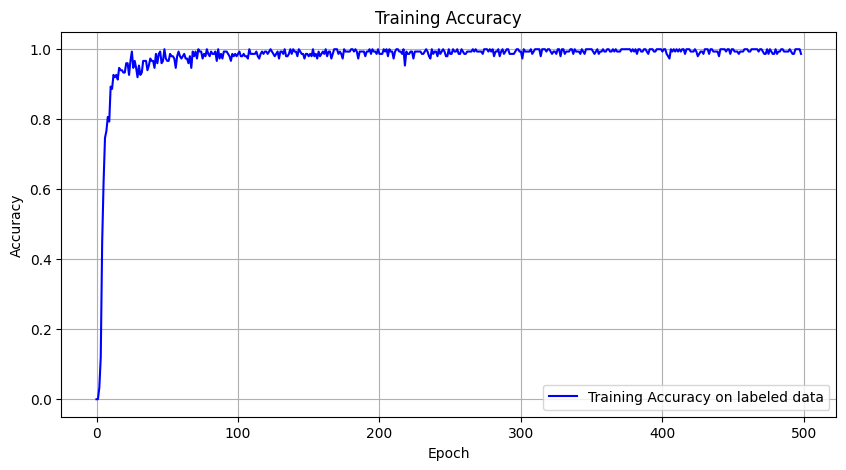

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(acuuracy_per_epoch[0:499], label='Training Accuracy on labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

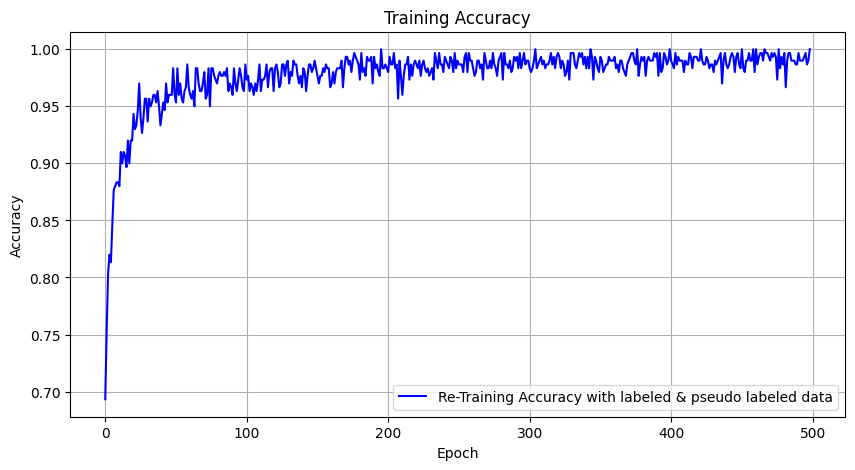

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(acuuracy_per_epoch[500:999], label='Re-Training Accuracy with labeled & pseudo labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Re-Training Accuracy with labeled & pseudo labeled data')
plt.legend()
plt.grid(True)
plt.show()

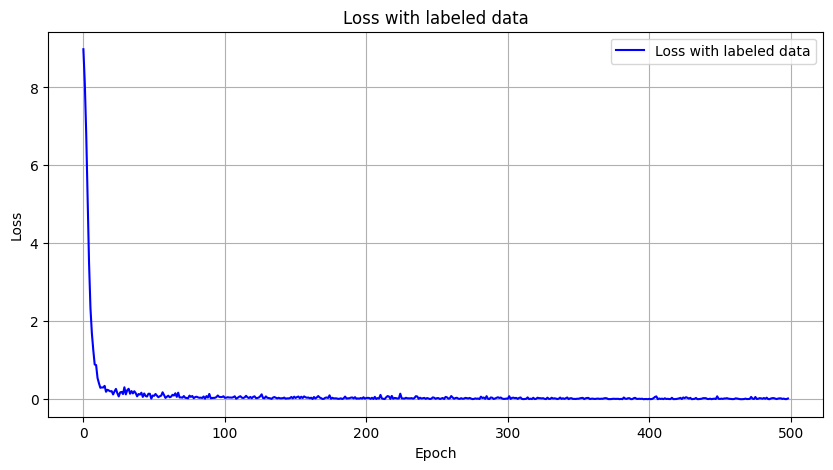

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_epoch[0:499], label='Loss with labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss with labeled data')
plt.legend()
plt.grid(True)
plt.show()

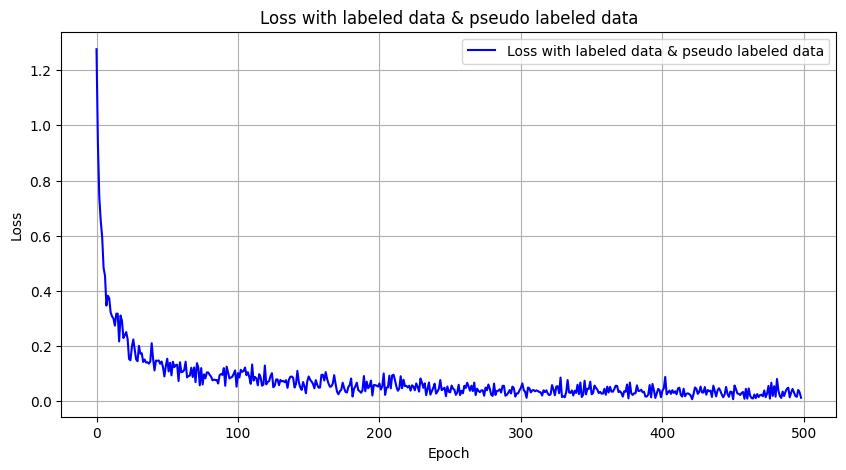

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_epoch[500:999], label='Loss with labeled data & pseudo labeled data', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss with labeled data & pseudo labeled data')
plt.legend()
plt.grid(True)
plt.show()